![GMV](https://upload.wikimedia.org/wikipedia/en/3/31/GMV_logo_small_gif.gif)  ![Apache Spark](http://spark.apache.org/images/spark-logo.png)

# KDD99 Unsupervised Learning

# Apache Spark Initialization

In [1]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext(appName="SecurityDataScience")

## 0. Libraries

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import * 
sqlContext = SQLContext(sc)

## 1. Data Description

**Intrinsic attributes**

These attributes are extracted from the headers' area of the network packets.

Col|Feature name  | description |	type
---|--------------|-------------|------------
1  |duration 	  |length (number of seconds) of the connection |continuous
2  |protocol_type |type of the protocol, e.g. tcp, udp, etc. |discrete
3  |service 	  |network service on the destination, e.g., http, telnet, etc. |discrete
4  |flag 	      |normal or error status of the connection. The possible status are this: SF, S0, S1, S2, S3, OTH, REJ, RSTO, RSTOS0, SH, RSTRH, SHR 	|discrete 
5  |src_bytes 	  |number of data bytes from source to destination 	|continuous
6  |dst_bytes 	  |number of data bytes from destination to source 	|continuous
7  |land 	      |1 if connection is from/to the same host/port; 0 otherwise 	|discrete
8  |wrong_fragment|sum of bad checksum packets in a connection 	|continuous
9  |urgent 	      |number of urgent packets. Urgent packets are packets with the urgent bit activated 	|continuous


**Class attribute**

The 42nd attribute is the ***class_attack*** attribute, it indicates which type of connections is each instance: normal or which attack. The values it can take are the following: *anomaly, dict, dict_simple, eject, eject-fail, ffb, ffb_clear, format, format_clear, format-fail, ftp-write, guest, imap, land, load_clear, loadmodule, multihop, perl_clear, perlmagic, phf, rootkit, spy, syslog, teardrop, warez, warezclient, warezmaster, pod, back, ip- sweep, neptune, nmap, portsweep, satan, smurf and normal*.

** Categories of class attribute **


class_attack |Category
-------|--------------
smurf| dos
neptune| dos
back| dos
teardrop| dos
pod| dos
land| dos
normal|normal
satan|probe
ipsweep|probe
portsweep|probe
nmap|probe
warezclient|r2l
guess_passwd|r2l
warezmaster|r2l
imap|r2l
ftp_write|r2l
multihop|r2l
phf|r2l
spy|r2l
buffer_overflow|u2r
rootkit|u2r
loadmodule|u2r
perl|u2r

## 2. Load Data

In [4]:
textFileConn = sc.textFile('./data/KDD/KDDTrain+.txt', 4)


In [5]:
#Creating the schema

#we define the name of the columns

columnNames=["class_attack", "duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
                 "wrong_fragment","urgent"]

In [6]:
#quick fields initialitation all for FloatType
connFields = [StructField(colName, FloatType(), True) for colName in columnNames]

In [7]:
#we proceed to modify the respective fields so that they reflect the correct data type:
connFields[0].dataType = StringType()
connFields[2].dataType = StringType()
connFields[3].dataType = StringType()
connFields[4].dataType = StringType()

In [8]:
# we can construct our schema, which we will use later below for building the data frame
connSchema = StructType(connFields)

In [9]:
#Parsing the file
def parseReg(p):
    return ( p[41]
            ,float(p[0])
            ,p[1], p[2], p[3] 
            ,float(p[4])
            ,float(p[5])
            ,float(p[6])
            ,float(p[7])
            ,float(p[8])
            )

In [10]:
connParsedFile = (textFileConn.map(lambda line: line.split(','))
                              .map(parseReg))

In [11]:
# We are now ready to build our data frame, using the connParsedFile RDD computed above and the schema 
# variable already calculated:
conn = sqlContext.createDataFrame(connParsedFile, connSchema)
conn.cache()

DataFrame[class_attack: string, duration: float, protocol_type: string, service: string, flag: string, src_bytes: float, dst_bytes: float, land: float, wrong_fragment: float, urgent: float]

In [12]:
conn.take(3)

[Row(class_attack='normal', duration=0.0, protocol_type='tcp', service='ftp_data', flag='SF', src_bytes=491.0, dst_bytes=0.0, land=0.0, wrong_fragment=0.0, urgent=0.0),
 Row(class_attack='normal', duration=0.0, protocol_type='udp', service='other', flag='SF', src_bytes=146.0, dst_bytes=0.0, land=0.0, wrong_fragment=0.0, urgent=0.0),
 Row(class_attack='neptune', duration=0.0, protocol_type='tcp', service='private', flag='S0', src_bytes=0.0, dst_bytes=0.0, land=0.0, wrong_fragment=0.0, urgent=0.0)]

In [13]:
conn.limit(4).toPandas()

,class_attack,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent
0,normal,0.0,tcp,ftp_data,SF,491.0,0.0,0.0,0.0,0.0
1,normal,0.0,udp,other,SF,146.0,0.0,0.0,0.0,0.0
2,neptune,0.0,tcp,private,S0,0.0,0.0,0.0,0.0,0.0
3,normal,0.0,tcp,http,SF,232.0,8153.0,0.0,0.0,0.0


In [14]:
#get all the distint values of class_attack
conn.select("class_attack").distinct().toPandas()

,class_attack
0,neptune
1,satan
2,nmap
3,portsweep
4,back
5,warezclient
6,guess_passwd
7,normal
8,rootkit
9,perl


## 3. Data Preparation

### 3.1 Encoding categorical features

In [15]:
from pyspark.sql import functions as F

In [16]:
def encodeCategorical(df, catName):
    #Encode the categorical variable in different columns foreach categories 
    #and the value is equal to 1 if the category is equal to column name and 0 otherwise. 
    #Finally drops the categorical variable
    
    categories = df.select(catName).distinct().toPandas()[catName]
    aux = df
    for c in categories:
        aux = aux.withColumn(c, F.when(df[catName] == c, 1).otherwise(0))
        
    return aux.drop(catName)

### Encoding *protocol_type*

In [17]:
conn.select("protocol_type").distinct().toPandas()

,protocol_type
0,tcp
1,udp
2,icmp


In [18]:
connEncoded = encodeCategorical(conn, "protocol_type")

In [19]:
connEncoded.limit(10).toPandas()

,class_attack,duration,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp
0,normal,0.0,ftp_data,SF,491.0,0.0,0.0,0.0,0.0,1,0,0
1,normal,0.0,other,SF,146.0,0.0,0.0,0.0,0.0,0,1,0
2,neptune,0.0,private,S0,0.0,0.0,0.0,0.0,0.0,1,0,0
3,normal,0.0,http,SF,232.0,8153.0,0.0,0.0,0.0,1,0,0
4,normal,0.0,http,SF,199.0,420.0,0.0,0.0,0.0,1,0,0
5,neptune,0.0,private,REJ,0.0,0.0,0.0,0.0,0.0,1,0,0
6,neptune,0.0,private,S0,0.0,0.0,0.0,0.0,0.0,1,0,0
7,neptune,0.0,private,S0,0.0,0.0,0.0,0.0,0.0,1,0,0
8,neptune,0.0,remote_job,S0,0.0,0.0,0.0,0.0,0.0,1,0,0
9,neptune,0.0,private,S0,0.0,0.0,0.0,0.0,0.0,1,0,0


### Encoding *service*

In [20]:
connEncoded.select("service").distinct().toPandas()

,service
0,telnet
1,ftp
2,auth
3,iso_tsap
4,systat
5,name
6,sql_net
7,ntp_u
8,X11
9,pop_3


In [21]:
connEncoded = encodeCategorical(connEncoded, "service")

In [22]:
connEncoded.limit(10).toPandas()

,class_attack,duration,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,...,http_443,echo,netstat,remote_job,gopher,imap4,uucp,ssh,rje,bgp
0,normal,0.0,SF,491.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,normal,0.0,SF,146.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,normal,0.0,SF,232.0,8153.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,normal,0.0,SF,199.0,420.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,neptune,0.0,REJ,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,1,0,0,0,0,0,0
9,neptune,0.0,S0,0.0,0.0,0.0,0.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Encoding *flag*

In [23]:
connEncoded.select("flag").distinct().toPandas()

,flag
0,RSTOS0
1,S3
2,SF
3,S0
4,OTH
5,REJ
6,RSTO
7,RSTR
8,SH
9,S2


In [24]:
connEncoded = encodeCategorical(connEncoded, "flag")

In [25]:
connEncoded.limit(10).toPandas()

,class_attack,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp,...,S3,SF,S0,OTH,REJ,RSTO,RSTR,SH,S2,S1
0,normal,0.0,491.0,0.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,normal,0.0,146.0,0.0,0.0,0.0,0.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,normal,0.0,232.0,8153.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,normal,0.0,199.0,420.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
5,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
6,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
7,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
8,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
9,neptune,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


###  Encoding *class_attack* (**label**) like Integers

In [26]:
connEncoded.select("class_attack").distinct().toPandas()

,class_attack
0,neptune
1,satan
2,nmap
3,portsweep
4,back
5,warezclient
6,guess_passwd
7,normal
8,rootkit
9,perl


In [27]:
categories = connEncoded.select("class_attack").distinct().toPandas()["class_attack"]

In [28]:
dictCategories = dict((v,int(k)) for (k,v) in categories.to_dict().items())

In [29]:
from pyspark.sql.functions import udf

In [30]:
def categoriesToInt(cat):
    return dictCategories[cat]

udfCategoriesToInt = udf(categoriesToInt, IntegerType())

In [31]:
connEncoded = connEncoded.withColumn("class_attack", udfCategoriesToInt("class_attack") )

In [32]:
connEncoded.limit(10).toPandas()

,class_attack,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp,...,S3,SF,S0,OTH,REJ,RSTO,RSTR,SH,S2,S1
0,7,0.0,491.0,0.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,7,0.0,146.0,0.0,0.0,0.0,0.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,7,0.0,232.0,8153.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,7,0.0,199.0,420.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
8,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


### 3.2 Input Normalization

http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#module-pyspark.ml.feature

In [33]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import DenseVector

In [34]:
connEncoded.limit(5).toPandas()

,class_attack,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp,...,S3,SF,S0,OTH,REJ,RSTO,RSTR,SH,S2,S1
0,7,0.0,491.0,0.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,7,0.0,146.0,0.0,0.0,0.0,0.0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
3,7,0.0,232.0,8153.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
4,7,0.0,199.0,420.0,0.0,0.0,0.0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [35]:
features = connEncoded.drop("class_attack")

In [36]:
features.limit(10).toPandas()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,tcp,udp,icmp,telnet,...,S3,SF,S0,OTH,REJ,RSTO,RSTR,SH,S2,S1
0,0.0,491.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.0,146.0,0.0,0.0,0.0,0.0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.0,232.0,8153.0,0.0,0.0,0.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.0,199.0,420.0,0.0,0.0,0.0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [37]:
stats = features.describe().toPandas()

In [38]:
minValue = np.array(stats[stats.summary=="min"].values[0][1:], float)

In [39]:
maxValue = np.array(stats[stats.summary=="max"].values[0][1:], float)

In [40]:
def minMaxScaler(minV, maxV, row):
    return DenseVector([(row[i]-minV[i])/(maxV[i]-minV[i]) for i in range(len(row))])
    

In [41]:
labeledData = connEncoded.rdd.map(lambda x: (x[0], minMaxScaler(minValue, maxValue, x[1:])))
# Apache Spark 1.6.0
#labeledData = connEncoded.map(lambda x: (x[0], minMaxScaler(minValue, maxValue, x[1:])))

In [42]:
labeledDataFrame = sqlContext.createDataFrame(labeledData, ["label", "features"])

In [43]:
labeledDataFrame.limit(5).toPandas()

,label,features
0,7,"[0.0, 3.55806409139e-07, 0.0, 0.0, 0.0, 0.0, 1..."
1,7,"[0.0, 1.05799869113e-07, 0.0, 0.0, 0.0, 0.0, 0..."
2,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
3,7,"[0.0, 1.6812033996e-07, 6.22396149447e-06, 0.0..."
4,7,"[0.0, 1.44206670914e-07, 3.20626006093e-07, 0...."


### 3.3 Principal Component Analysis (PCA)

In [44]:
from pyspark.ml.feature import PCA

In [45]:
v = labeledDataFrame.limit(1).toPandas()["features"].values[0]
n_features = len(v.array)
print("Total number of features: %d" %n_features)

Total number of features: 90


In [46]:
def estimateCovariance(df):
    """Compute the covariance matrix for a given dataframe.

    Note:
        The multi-dimensional covariance array should be calculated using outer products.  Don't
        forget to normalize the data by first subtracting the mean.

    Args:
        df:  A Spark dataframe with a column named 'features', which (column) consists of DenseVectors.

    Returns:
        np.ndarray: A multi-dimensional array where the number of rows and columns both equal the
            length of the arrays in the input dataframe.
    """
    m = df.select(df['features']).rdd.map(lambda x: x[0]).mean()
    dfZeroMean = df.select(df['features']).rdd.map(lambda x:   x[0]).map(lambda x: x-m)  # subtract the mean

    return dfZeroMean.map(lambda x: np.outer(x,x)).sum()/df.count()

In [47]:
from numpy.linalg import eigh

def pca(df, k=2):
    """Computes the top `k` principal components, corresponding scores, and all eigenvalues.

    Note:
        All eigenvalues should be returned in sorted order (largest to smallest). `eigh` returns
        each eigenvectors as a column.  This function should also return eigenvectors as columns.

    Args:
        df: A Spark dataframe with a 'features' column, which (column) consists of DenseVectors.
        k (int): The number of principal components to return.

    Returns:
        tuple of (np.ndarray, RDD of np.ndarray, np.ndarray): A tuple of (eigenvectors, `RDD` of
        scores, eigenvalues).  Eigenvectors is a multi-dimensional array where the number of
        rows equals the length of the arrays in the input `RDD` and the number of columns equals
        `k`.  The `RDD` of scores has the same number of rows as `data` and consists of arrays
        of length `k`.  Eigenvalues is an array of length d (the number of features).
     """
    cov = estimateCovariance(df)
    col = cov.shape[1]
    eigVals, eigVecs = eigh(cov)
    inds = np.argsort(eigVals)
    eigVecs = eigVecs.T[inds[-1:-(col+1):-1]]  
    components = eigVecs[0:k]
    eigVals = eigVals[inds[-1:-(col+1):-1]]  # sort eigenvals
    score = df.select(df['features']).rdd.map(lambda x: x[0]).map(lambda x: np.dot(x, components.T) )
    # Return the `k` principal components, `k` scores, and all eigenvalues

    return components.T, score, eigVals

In [48]:
comp, score, eigVals = pca(labeledDataFrame)

In [49]:
varianceExplained = eigVals.cumsum()/eigVals.sum()

In [50]:
varianceExplained

array([ 0.29479691,  0.48615106,  0.56380045,  0.63536068,  0.69545384,
        0.75040061,  0.78239749,  0.80551199,  0.82220474,  0.83877532,
        0.85081663,  0.86054083,  0.86927623,  0.87724528,  0.88409997,
        0.88930303,  0.89344096,  0.89728165,  0.90089252,  0.90433219,
        0.90765466,  0.9108735 ,  0.9140275 ,  0.91716524,  0.92021357,
        0.92318417,  0.9261157 ,  0.92901054,  0.93184957,  0.93457327,
        0.9371558 ,  0.93969323,  0.94217673,  0.94462305,  0.94704482,
        0.94943382,  0.95178615,  0.9540581 ,  0.95625777,  0.95843117,
        0.96059782,  0.96271828,  0.96481763,  0.96689013,  0.96891292,
        0.9708982 ,  0.97286566,  0.97479129,  0.97666524,  0.97851848,
        0.98025443,  0.98191773,  0.98356335,  0.98515445,  0.98659116,
        0.9879796 ,  0.98935899,  0.99071217,  0.99204842,  0.99323988,
        0.9943655 ,  0.99518698,  0.9959188 ,  0.99659168,  0.99709125,
        0.9974935 ,  0.99786108,  0.99821679,  0.99855202,  0.99

In [51]:
import matplotlib.pyplot as plt

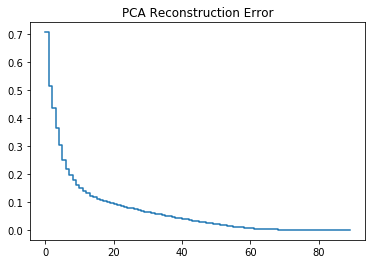

In [52]:
plt.plot(1 - varianceExplained, drawstyle = 'steps-post')
plt.title('PCA Reconstruction Error');

In [53]:
n_factors = ((1 - varianceExplained) > 0.10).sum()
print("Number of factors with 10% of reconstraction Error: ", n_factors)

Number of factors with 10% of reconstraction Error:  18


#### 3.2.1 Apache Spark Implementation

In [54]:
#Apache Spark API
pca = PCA(k = n_factors, inputCol="features", outputCol="pca_features")

In [55]:
labeledDataFrame

DataFrame[label: bigint, features: vector]

In [56]:
pcaModel = pca.fit(labeledDataFrame)

In [57]:
pcaDataFrame = pcaModel.transform(labeledDataFrame).drop("features")

In [58]:
pcaDataFrame.limit(10).toPandas()

,label,pca_features
0,7,"[0.409209598614, 0.562220389984, 0.26001162083..."
1,7,"[0.832928115243, -0.470423690463, -0.154922860..."
2,0,"[-1.05608529027, 0.357185323968, -0.1621020556..."
3,7,"[0.708890308228, 1.18144041391, -0.04838918782..."
4,7,"[0.708890308288, 1.18144041392, -0.04838918765..."
5,0,"[-0.602476528018, 0.446572574243, -1.056949664..."
6,0,"[-1.05608529027, 0.357185323968, -0.1621020556..."
7,0,"[-1.05608529027, 0.357185323968, -0.1621020556..."
8,0,"[-0.784319733615, 0.512735904211, 0.3915276334..."
9,0,"[-1.05608529027, 0.357185323968, -0.1621020556..."


### 3.4 Sampling

In [59]:
# Sampling with replacement with the 30% of data
trainingData = pcaDataFrame.sample(withReplacement = True, fraction = 0.30, seed= 1).cache()

In [60]:
trainingData.limit(10).toPandas()

,label,pca_features
0,7,"[0.409209598614, 0.562220389984, 0.26001162083..."
1,0,"[-1.05608529027, 0.357185323968, -0.1621020556..."
2,7,"[0.708890308228, 1.18144041391, -0.04838918782..."
3,7,"[0.708890308288, 1.18144041392, -0.04838918765..."
4,0,"[-1.05608529027, 0.357185323968, -0.1621020556..."
5,7,"[0.832525939998, -0.471136989247, -0.157142752..."
6,7,"[0.38485988636, 0.558869626936, 0.181938024604..."
7,0,"[-0.77516353332, 0.515957014487, 0.51029877751..."
8,7,"[0.708890308281, 1.18144041392, -0.04838918767..."
9,0,"[-0.792950179433, 0.512499516514, 0.4056604126..."


## 4. Modeling

## 4.1 Cluster metrics

Two desirable objectives for any cluster assignment:
* **homogeneity**: each cluster contains only members of a single class.
* **completeness**: all members of a given class are assigned to the same cluster.

The main cluster metrics are:

* **Homogeneity Score**: A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.
    * Bounded scores: 0.0 is as bad as it can be, 1.0 is a perfect score

* **Completeness Score**: A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.
    * Bounded scores: 0.0 is as bad as it can be, 1.0 is a perfect score

* **V measure Scores** : the harmonic mean between homogeneity and completeness: v = 2 * (homogeneity * completeness) / (homogeneity + completeness)
    * Bounded scores: 0.0 is as bad as it can be, 1.0 is a perfect score

## 4.2 K-means

* *k:* number of desired clusters.
* *maxIter:* maximum number of iterations to run.
* *initMode:* specifies either random initialization or initialization via k-means.
* *initSteps:* determines the number of steps in the k-means|| algorithm.
* *tol:* determines the distance threshold within which we consider k-means to have converged.
* initialModel:* an optional set of cluster centers used for initialization. If this parameter is supplied, only one run is performed.

In [61]:
from pyspark.ml.clustering import KMeans

### 4.2.1 Random centroid initialization (5 clusters)

In [62]:
kmeans = KMeans(k = 5, initMode = "random", initSteps = 10, 
                featuresCol = "pca_features", maxIter = 10, tol = 1e-3 )

In [63]:
model = kmeans.fit(trainingData)

In [64]:
clusterCenters = model.clusterCenters()

In [65]:
pd.DataFrame(clusterCenters)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,-0.756975,0.490356,-0.014459,0.242239,0.090813,0.327151,-0.022699,0.082133,-0.020125,0.182277,-0.098614,0.084975,0.285699,-0.012474,-0.168918,0.055832,0.030286,0.003886
1,0.650380,1.184474,-0.095523,0.353500,0.206118,0.297145,-0.026133,0.095054,-0.029303,0.207297,-0.094247,0.081003,0.285437,-0.012379,-0.166336,0.048752,0.027342,0.003634
2,0.389314,0.559238,0.211157,-0.011284,-0.184933,0.837689,-0.530756,0.093892,-0.019505,0.180804,-0.238945,0.148952,0.339047,-0.013013,-0.162901,0.044917,0.015419,0.001257
3,0.827714,-0.613317,-0.299953,0.662447,-0.024552,0.341373,-0.026750,0.052787,-0.029028,0.232193,-0.097781,0.073102,0.262497,-0.013450,-0.141897,0.043714,0.024290,0.002459
4,0.612317,0.147976,0.415507,-0.312843,0.244431,0.522398,0.259443,0.156910,-0.051319,0.243222,-0.034822,0.055132,0.285826,-0.009043,-0.170637,0.028018,0.021265,0.002102


In [66]:
predictedData = model.transform(pcaDataFrame)
predictedData.cache()

DataFrame[label: bigint, pca_features: vector, prediction: int]

In [67]:
predictedData.limit(10).toPandas()

,label,pca_features,prediction
0,7,"[0.409209598614, 0.562220389984, 0.26001162083...",2
1,7,"[0.832928115243, -0.470423690463, -0.154922860...",3
2,0,"[-1.05608529027, 0.357185323968, -0.1621020556...",0
3,7,"[0.708890308228, 1.18144041391, -0.04838918782...",1
4,7,"[0.708890308288, 1.18144041392, -0.04838918765...",1
5,0,"[-0.602476528018, 0.446572574243, -1.056949664...",0
6,0,"[-1.05608529027, 0.357185323968, -0.1621020556...",0
7,0,"[-1.05608529027, 0.357185323968, -0.1621020556...",0
8,0,"[-0.784319733615, 0.512735904211, 0.3915276334...",0
9,0,"[-1.05608529027, 0.357185323968, -0.1621020556...",0


In [68]:
# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(row, centers):
    center = centers[row["prediction"]]
    point = row["pca_features"]
    return np.sqrt(np.sum([x**2 for x in (point - center)]))

In [69]:
print("KMeans error:" , predictedData.rdd.map(lambda row: error(row, clusterCenters)).reduce(lambda a,b : a+b))

KMeans error: 81653.77703


In [70]:
kmeansMeasures = predictedData.groupBy(predictedData.label, predictedData.prediction).count().toPandas()

In [71]:
#completeness (all members of a given class are assigned to the same cluster)
print("Completeness:" , 1.0*np.sum(kmeansMeasures.groupby("label")["count"].max())/np.sum(kmeansMeasures["count"]))

Completeness: 0.742579759155


In [72]:
kmeansMeasures[kmeansMeasures.label==3]

,label,prediction,count
18,3,1,11
21,3,0,2900
40,3,2,13
46,3,4,7


In [73]:
#homogeneity (each cluster contains only members of a single class.)
print("Homogeneity:", 1.0*np.sum(kmeansMeasures.groupby("prediction")["count"].max())/np.sum(kmeansMeasures["count"]))

Homogeneity: 0.852389003993


In [74]:
kmeansMeasures[kmeansMeasures.prediction==2]

,label,prediction,count
0,7,2,8036
1,12,2,56
2,10,2,29
4,14,2,6
8,9,2,3
11,21,2,9
13,11,2,7
15,6,2,2
22,13,2,20
24,16,2,2


### 4.2.2 Finding the optimal number of clusters

In [75]:
def kmeansClusterMeasures(n_Clusters, dataFrame, seed = None):
    #build a kmean cluster from dataFrame and with n_Clusters centroides
    #and returns the error, completeness and homogeneity of kmean's model

    trainingData, testData = dataFrame.randomSplit([70.0, 30.0], seed= seed)
    
    kmeans = KMeans(k = n_Clusters, initMode = "random", initSteps = 10, 
                    featuresCol = "pca_features", maxIter = 10, tol = 1e-3 )
    model = kmeans.fit(trainingData)
    centers = model.clusterCenters()
    
    predictedData = model.transform(testData)
    predictedData.cache()
    
    errorKmeans =  predictedData.rdd.map(lambda row: error(row, centers)).reduce(lambda a,b : a+b)
    
    kmeansMeasures = predictedData.groupBy(predictedData.label, predictedData.prediction).count().toPandas()
    completeness = 1.0*np.sum(kmeansMeasures.groupby("label")["count"].max())/np.sum(kmeansMeasures["count"])
    homogeneity = 1.0*np.sum(kmeansMeasures.groupby("prediction")["count"].max())/np.sum(kmeansMeasures["count"])
    
    
    return n_Clusters, errorKmeans, completeness, homogeneity

In [76]:
def findBestCluster(minNClusters, maxNClusters, dataFrame, seed = None):
    nClusters = np.arange(minNClusters, maxNClusters+1)
    kmeansMeasures = [kmeansClusterMeasures(n, trainingData, seed) for n in nClusters]
    return pd.DataFrame(kmeansMeasures, 
                        columns = ["nClusters", "error", "completeness", "homogeneity"],
                       index = nClusters)

In [77]:
%%time
print(kmeansClusterMeasures(5, trainingData))

(5, 7503.5641135193064, 0.72716854724964741, 0.83621297602256695)
CPU times: user 20 ms, sys: 20 ms, total: 40 ms
Wall time: 1.66 s


In [78]:
%%time
kmeansMeasures = findBestCluster(4, 20, trainingData, seed= 2)

CPU times: user 390 ms, sys: 100 ms, total: 490 ms
Wall time: 19.1 s


In [79]:
kmeansMeasures

,nClusters,error,completeness,homogeneity
4,4,7742.452945,0.739427,0.855424
5,5,7322.885544,0.664042,0.846487
6,6,5868.925632,0.671120,0.854008
7,7,5807.724123,0.609007,0.870996
8,8,5753.334346,0.661033,0.849230
9,9,5495.436715,0.662184,0.849761
10,10,4884.361844,0.651389,0.851265
11,11,4307.633412,0.661122,0.890993
12,12,4872.591194,0.663157,0.873031
13,13,2912.266860,0.549283,0.861794


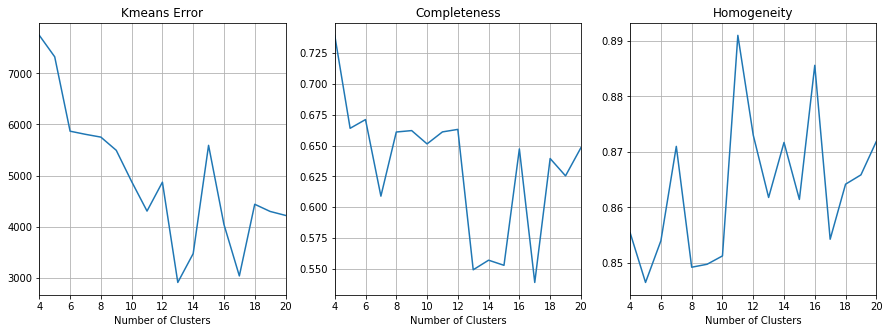

In [80]:
fig, axes = plt.subplots(1, 3)
kmeansMeasures.error.plot(ax=axes[0],title="Kmeans Error", grid = True, figsize=(15,5))
axes[0].set_xlabel("Number of Clusters")
kmeansMeasures.completeness.plot(ax=axes[1],title="Completeness", grid = True)
axes[1].set_xlabel("Number of Clusters")
kmeansMeasures.homogeneity.plot(ax=axes[2],title="Homogeneity", grid = True)
axes[2].set_xlabel("Number of Clusters");

#### Create the clusters with  9 centroids

In [81]:
%%time
n_centroids = 9
kmeans = KMeans(k = n_centroids, initMode = "random", initSteps = 10, 
                featuresCol = "pca_features", maxIter = 10, tol = 1e-3 )
model = kmeans.fit(trainingData)
clusterCenters = model.clusterCenters()

CPU times: user 20 ms, sys: 20 ms, total: 40 ms
Wall time: 277 ms


In [82]:
%%time
predictedData = model.transform(pcaDataFrame)
predictedData.cache()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.8 ms


In [83]:
predictedData.limit(5).toPandas()

,label,pca_features,prediction
0,7,"[0.409209598614, 0.562220389984, 0.26001162083...",0
1,7,"[0.832928115243, -0.470423690463, -0.154922860...",6
2,0,"[-1.05608529027, 0.357185323968, -0.1621020556...",2
3,7,"[0.708890308228, 1.18144041391, -0.04838918782...",1
4,7,"[0.708890308288, 1.18144041392, -0.04838918765...",1


#### Visualize the results on PCA-reduced data

In [84]:
from pyspark.ml.feature import PCA
from pyspark.sql import Row

In [85]:
pca = PCA(k=2, inputCol="pca_features", outputCol="pca_2D")
modelPCA = pca.fit(predictedData)
projectedDT = modelPCA.transform(predictedData)

In [86]:
projectedDT.limit(5).toPandas()

,label,pca_features,prediction,pca_2D
0,7,"[0.409209598614, 0.562220389984, 0.26001162083...",0,"[-0.409209598614, -0.562220389984]"
1,7,"[0.832928115243, -0.470423690463, -0.154922860...",6,"[-0.832928115243, 0.470423690463]"
2,0,"[-1.05608529027, 0.357185323968, -0.1621020556...",2,"[1.05608529027, -0.357185323968]"
3,7,"[0.708890308228, 1.18144041391, -0.04838918782...",1,"[-0.708890308228, -1.18144041391]"
4,7,"[0.708890308288, 1.18144041392, -0.04838918765...",1,"[-0.708890308288, -1.18144041392]"


In [87]:
clusterCentersDF = sc.parallelize(
    [Row(n, DenseVector(cluster.tolist())) for n, cluster in zip(range(len(clusterCenters)), clusterCenters)]
).toDF(["prediction", "pca_features"])

In [88]:
clusterCentersDF.toPandas()

,prediction,pca_features
0,0,"[0.398365155089, 0.558651422671, 0.21874156634..."
1,1,"[0.708890306067, 1.18144041007, -0.04838919974..."
2,2,"[-0.89063007291, 0.453633329576, 0.19296573971..."
3,3,"[-0.357412203011, 0.640396918958, -0.621774230..."
4,4,"[-0.360037073965, 1.14540238378, 0.10989426381..."
5,5,"[0.708879338879, 1.18142095858, -0.04844973558..."
6,6,"[0.704869611597, -0.399964487172, -0.078917989..."
7,7,"[0.418607344991, 0.563608899885, 0.25331697448..."
8,8,"[0.87960702744, -0.525177443217, 0.05340324986..."


In [89]:
clusterCenters2D = modelPCA.transform(clusterCentersDF)

In [90]:
centers2D = clusterCenters2D.rdd.map(lambda row: (row["prediction"], row["pca_2D"]))\
                            .map(lambda v: Row(prediction = v[0], x1 = v[1].values.tolist()[0],\
                                                     x2 = v[1].values.tolist()[1]))\
                            .toDF().toPandas()

In [91]:
n_points = 1000
points2D = projectedDT.limit(n_points).rdd\
                      .map(lambda row: (row["label"], row["prediction"], row["pca_2D"]))\
                      .map(lambda v: Row(label = v[0], 
                                                prediction = v[1], 
                                                x1 = v[2].values.tolist()[0], 
                                                x2 = v[2].values.tolist()[1]))\
                       .toDF().toPandas()

In [92]:
points2D.head()

,label,prediction,x1,x2
0,7,0,-0.409210,-0.562220
1,7,6,-0.832928,0.470424
2,0,2,1.056085,-0.357185
3,7,1,-0.708890,-1.181440
4,7,1,-0.708890,-1.181440


In [93]:
# set colors
from matplotlib import colors
import six
colors_ = []
selected_colors = ['blue', 'red', 'orange', 'green', 'purple', 'black', 'grey', 'darkred', 'lightgreen']

# Add the single letter colors.
for name, rgb in six.iteritems(colors.ColorConverter.colors):
    hex_ = colors.rgb2hex(rgb)
    if name in selected_colors:
        colors_.append((name, hex_))

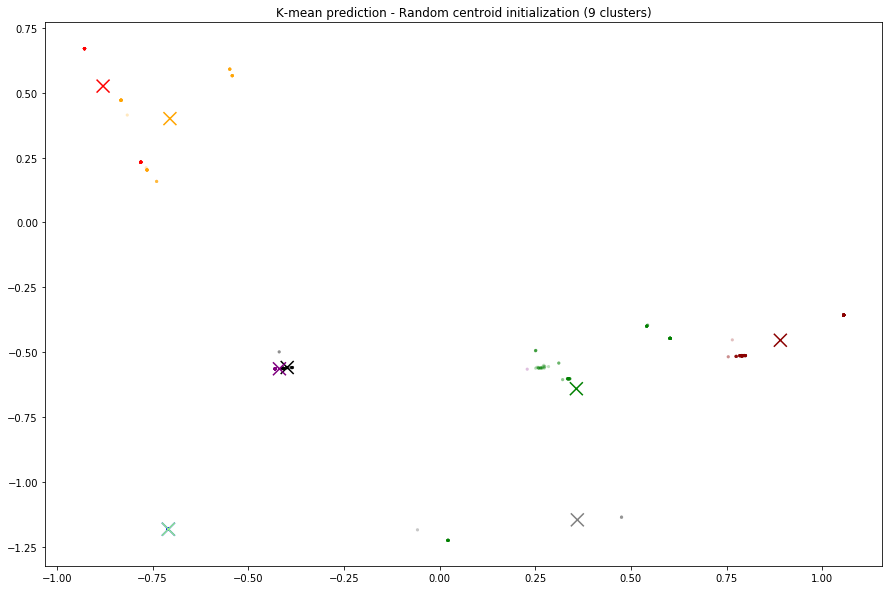

In [94]:
plt.figure(figsize= (15, 10))
# Plot the clusters
for i, color in zip(set(points2D.prediction), colors_):
    idx = np.where(points2D.prediction == i)
    plt.scatter(points2D.values[idx, 2], points2D.values[idx, 3], c= color, s = 10, label=i, alpha = 0.25, edgecolors='none')
    # Plot the centroids as X
    plt.scatter(centers2D.values[i, 1], centers2D.values[i, 2],
            marker='x', s=169, linewidths=3,
            color=color, zorder=10)
plt.title('K-mean prediction - Random centroid initialization (9 clusters)')

#### Visualize the results on PCA-reduced data 3D

In [95]:
pca = PCA(k=3, inputCol="pca_features", outputCol="pca_3D")
modelPCA = pca.fit(predictedData)
projectedDT = modelPCA.transform(predictedData)

In [96]:
projectedDT.limit(5).toPandas()

,label,pca_features,prediction,pca_3D
0,7,"[0.409209598614, 0.562220389984, 0.26001162083...",0,"[-0.409209598614, -0.562220389984, -0.26001162..."
1,7,"[0.832928115243, -0.470423690463, -0.154922860...",6,"[-0.832928115243, 0.470423690463, 0.154922860874]"
2,0,"[-1.05608529027, 0.357185323968, -0.1621020556...",2,"[1.05608529027, -0.357185323968, 0.162102055649]"
3,7,"[0.708890308228, 1.18144041391, -0.04838918782...",1,"[-0.708890308228, -1.18144041391, 0.0483891878..."
4,7,"[0.708890308288, 1.18144041392, -0.04838918765...",1,"[-0.708890308288, -1.18144041392, 0.0483891876..."


In [97]:
clusterCentersDF = sc.parallelize(
    [Row(n, DenseVector(cluster.tolist())) for n, cluster in zip(range(len(clusterCenters)), clusterCenters)]
).toDF(["prediction", "pca_features"])

In [98]:
clusterCentersDF.toPandas()

,prediction,pca_features
0,0,"[0.398365155089, 0.558651422671, 0.21874156634..."
1,1,"[0.708890306067, 1.18144041007, -0.04838919974..."
2,2,"[-0.89063007291, 0.453633329576, 0.19296573971..."
3,3,"[-0.357412203011, 0.640396918958, -0.621774230..."
4,4,"[-0.360037073965, 1.14540238378, 0.10989426381..."
5,5,"[0.708879338879, 1.18142095858, -0.04844973558..."
6,6,"[0.704869611597, -0.399964487172, -0.078917989..."
7,7,"[0.418607344991, 0.563608899885, 0.25331697448..."
8,8,"[0.87960702744, -0.525177443217, 0.05340324986..."


In [99]:
clusterCenters3D = modelPCA.transform(clusterCentersDF)

In [100]:
centers3D = clusterCenters3D.rdd.map(lambda row: (row["prediction"], row["pca_3D"]))\
                            .map(lambda v: Row(prediction = v[0], 
                                                       x1 = v[1].values.tolist()[0], 
                                                       x2 = v[1].values.tolist()[1],
                                                       x3 = v[1].values.tolist()[2]))\
                            .toDF().toPandas()

In [101]:
centers3D

,prediction,x1,x2,x3
0,0,-0.398365,-0.558651,-0.218742
1,1,-0.708890,-1.181440,0.048389
2,2,0.890630,-0.453633,-0.192966
3,3,0.357412,-0.640397,0.621774
4,4,0.360037,-1.145402,-0.109894
5,5,-0.708879,-1.181421,0.048450
6,6,-0.704870,0.399964,0.078918
7,7,-0.418607,-0.563609,-0.253317
8,8,-0.879607,0.525177,-0.053403


In [102]:
n_points = 1000
points3D = projectedDT.limit(n_points).rdd\
                      .map(lambda row: (row["label"], row["prediction"], row["pca_3D"]))\
                      .map(lambda v: Row(label = v[0], 
                                                prediction = v[1], 
                                                x1 = v[2].values.tolist()[0], 
                                                x2 = v[2].values.tolist()[1],
                                                x3 = v[2].values.tolist()[2]))\
                       .toDF().toPandas()

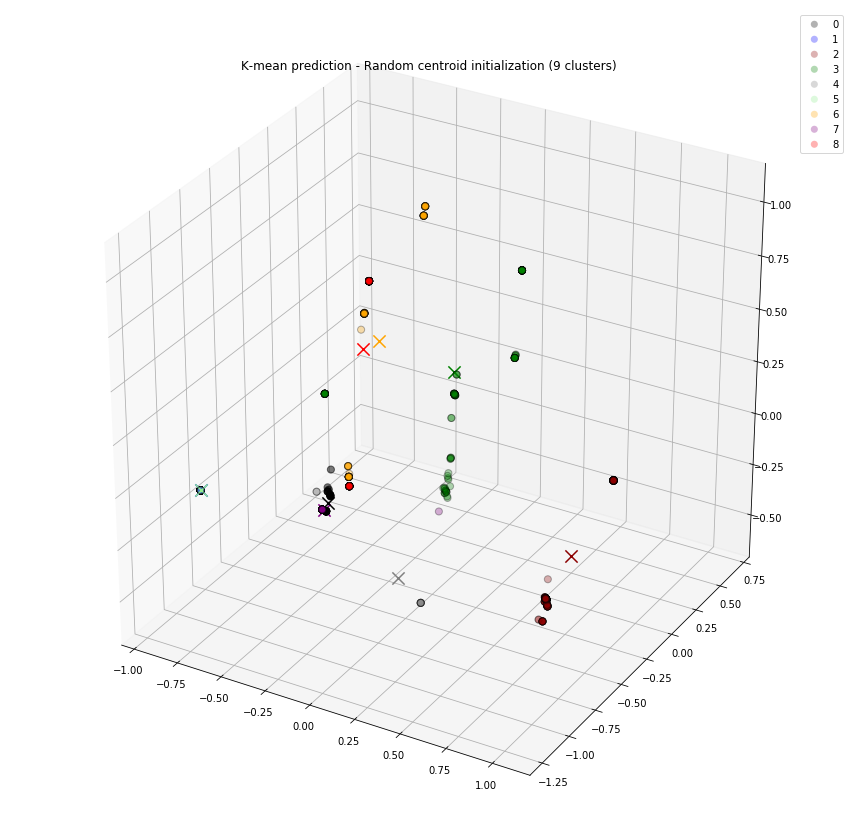

In [103]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')

# Plot the clusters
for i, color in zip(set(points3D.prediction), colors_):
    idx = np.where( points3D.prediction == i)
    ax.scatter(points3D.values[idx, 2], points3D.values[idx, 3], points3D.values[idx, 4],
               c=color, label=i, s=50, alpha = 0.3, 
               edgecolors='none')
    # Plot the centroids as X
    ax.scatter(centers3D.values[i, 1], centers3D.values[i, 2], centers3D.values[i, 3], 
               marker='x', linewidths=3, s = 150,
               color=color, zorder=10)
ax.set_title('K-mean prediction - Random centroid initialization (9 clusters)')
ax.legend();